In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from math import floor, log, pi, exp
import pickle

import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('..')))
import dsdes as ds

# Graphical parameters
params = {
   'axes.labelsize': 8,
   'font.size': 11,
   'legend.fontsize': 11,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': True,
   'figure.figsize': [10, 8],
   'figure.constrained_layout.use': True
   }
rcParams.update(params)

# Graph colors
lgreen = '#00502f'
lgreent = '#00502f88'
lred = '#910000'
lbrightred = '#c70000'
lcream = '#f6eee5'
lcoral = '#ff4a36'
lcoralt = '#ff4a3688'
lblack = '#212121'

# Scheme parameters
#theseed = 1392917848  # better rates
theseed = 4392327879
#theseed = 1334917848 # the one Jan and Elena didn't like
rng = np.random.default_rng(seed=theseed)

# Parameters to control
hurst = 0.6
time_steps = 2**10
extra_steps = 2**3 # this cannot be used as I intended initially, it is being used differently
dt = 1/time_steps

points = 10**4
half_support = 10

sample_paths = 1 * 10**4
y0 = rng.normal(size=sample_paths)
time_start = 0
time_end = 1

## Nonlinear functions
def nonlinear1(x):
    return np.sin(x)

def nonlinear2(x):
    return np.cos(x)

def nonlinear3(x):
    return np.sin(10*x)

def nonlinear4(x):
    return np.cos(10*x)

def nonlinear5(x):
    return 1/(1 + np.exp(-100*(x - 0.2)))

def nonlinear6(x):
    return 1/(1 + np.exp(100*(x - 0.2)))

Plot functions

In [4]:
def plot_generators(gen1, gen2, grid, save=False):
    """
    Plots the generators of the drift, either Weierstrass or fBm
    """
    fig, ax = plt.subplots()
    ax.plot(grid, gen1,  linewidth='1', color=lgreent)
    ax.plot(grid, gen2,  linewidth='1', color=lred)
    legend = ax.legend(framealpha=1)
    frame = legend.get_frame()
    frame.set_facecolor(lcream)
    frame.set_edgecolor(lcream)
    ax.grid(linestyle='--', linewidth='0.5', color='gray')
    if save:
        fig.savefig(f'sde_gen_{save}.png')
        fig.savefig(f'sde_gen_{save}.pdf')
        fig.savefig(f'sde_gen_{save}.eps')
    plt.show()

def plot_drift(drift1, drift2, bridge, grid, save=False, name=''):
    """
    Plot drifts (drift1 and drift2) generated with different variances
    and compares them with their generator (bridge)

    Optionally saves the figure if save=True
    and appends an identifier to the file name using 'name'
    """
    fig, ax = plt.subplots()
    ax.plot(grid, drift2,  linewidth='1', color=lgreent, label=r'$b^N$ for $N=$' + str(floor(1/var2)))
    ax.plot(grid, drift1,  linewidth='1', color=lred, label=r'$b^N$ for $N=$' + str(floor(1/var1)))
    ax.plot(grid, bridge,  linewidth='1', color=lgreen, label=r'$B^H_b$')
    legend = ax.legend(framealpha=1)
    frame = legend.get_frame()
    frame.set_facecolor(lcream)
    frame.set_edgecolor(lcream)
    ax.grid(linestyle='--', linewidth='0.5', color='gray')
    if save:
        fig.savefig(f'sde_drift_{name}.png')
        fig.savefig(f'sde_drift_{name}.pdf')
        fig.savefig(f'sde_drift_{name}.eps')
    plt.show()


def plot_mckean_drift(drift1, drift2, law1, law2, nl, grid, save=False, name=''):
    """
    Plots the three row figure for the McKean drift

    Plots:
    - the drifts drift1 and drift2
    - its laws law1 and law2
    - and finally the product

    The nonlinear function nl is applied to the given laws to plot
    both in the second and third row

    Optionally saves the figure if save=True
    and appends an identifier to the file name using 'name'
    """
    fig, axs = plt.subplots(3, 1)
    axs[0].set_title(r'Function $b^N$')
    axs[0].plot(grid, drift2,  linewidth='1', label=r'$b^N$ for $N=$' + str(floor(1/var2)), color=lcoral, alpha=0.7)
    axs[0].plot(grid, drift1,  linewidth='1', label=r'$b^N$ for $N=$' + str(floor(1/var1)), color=lgreen)
    axs[1].set_title(r'Law density as obtained by solving FPE for $b^N$')
    axs[1].plot(grid, nl(law2.data[-1]),  linewidth='1', label=r'$F(\rho^N)$ for $N=$' + str(floor(1/var2)), color=lcoral, alpha=0.7)
    axs[1].plot(grid, nl(law1.data[-1]),  linewidth='1', label=r'$F(\rho^N)$ for $N=$' + str(floor(1/var1)), color=lgreen)
    axs[2].set_title(r'McKean equation drift')
    axs[2].plot(grid, nl(law2.data[-1])*drift2,  linewidth='1', label=r'$F(\rho^N)b^N$ for $N=$' + str(floor(1/var2)), color=lcoral, alpha=0.7)
    axs[2].plot(grid, nl(law1.data[-1])*drift1,  linewidth='1', label=r'$F(\rho^N)b^N$ for $N=$' + str(floor(1/var1)), color=lgreen)
    for ax in axs:
        legend = ax.legend(framealpha=1, loc='upper right')
        frame = legend.get_frame()
        frame.set_facecolor(lcream)
        frame.set_edgecolor(lcream)
        ax.grid(linestyle='--', linewidth='0.5', color='gray')
    fig.suptitle(r'Action of $F(v^N)$ on $b^N$', fontsize=14)
    if save:
        fig.savefig(f'mckean_drift_{name}.png')
        fig.savefig(f'mckean_drift_{name}.pdf')
        fig.savefig(f'mckean_drift_{name}.eps')
    plt.show()


def plot_law(soln, law, grid, save=False, name=''):
    """
    Plots the empirical density of the SDE at terminal time and compares it
    with the obtained by solving the Fokker-Planck PDE

    Optionally saves the figure if save=True
    and appends an identifier to the file name using 'name'
    """
    fig, ax = plt.subplots()
    ax.hist(soln[0, :], bins=100, density=True, color=lred, alpha=0.85, label='Empirical density')
    ax.plot(grid, np.array(law.data)[-1, :], color=lgreen, label='FP PDE solution')
    ax.set_title('SDE densities')
    legend = ax.legend(framealpha=1)
    frame = legend.get_frame()
    frame.set_facecolor(lcream)
    frame.set_edgecolor(lcream)
    ax.grid(linestyle='--', linewidth='0.5', color='gray')
    if save:
        fig.savefig(f'sde_law_{name}.png')
        fig.savefig(f'sde_law_{name}.pdf')
        fig.savefig(f'sde_law_{name}.eps')
    plt.show()


def plot_mckean_law(soln1, soln2, grid, title1, title2, save=False, name=''):
    """
    Plots the empirical density of the McKean SDE at terminal time and compares it
    with the obtained by solving the Fokker-Planck PDE

    ¡¡¡¡¡¡¡¡¡This is needed because the solution of a McKean SDE and the solver of a linear
    SDE have different return values!!!!!!!!!!!!!!!

    Optionally saves the figure if save=True
    and appends an identifier to the file name using 'name'
    """
    fig, axs = plt.subplots(2, 1)
    axs[0].set_title(title1)
    axs[0].hist(soln1[0][0, :], bins=100, density=True, color=lred, alpha=0.85, label='Empirical density')
    axs[0].plot(grid, np.array(soln1[1].data)[-1, :], color=lgreen, label='FP PDE solution')
    axs[1].set_title(title2)
    axs[1].hist(soln2[0][0, :], bins=100, density=True, color=lred, alpha=0.85, label='Empirical density')
    axs[1].plot(grid, np.array(soln2[1].data)[-1, :], color=lgreen, label='FP PDE solution')
    fig.suptitle('MVSDE densities', fontsize=14)
    for ax in axs:
        legend = ax.legend(framealpha=1)
        frame = legend.get_frame()
        frame.set_facecolor(lcream)
        frame.set_edgecolor(lcream)
        ax.grid(linestyle='--', linewidth='0.5', color='gray')
    if save:
        fig.savefig(f'mckean_law_{name}.png')
        fig.savefig(f'mckean_law_{name}.pdf')
        fig.savefig(f'mckean_law_{name}.eps')
    plt.show()


def plot_wdrift(drift, weier, grid, save=False, name=''):
    fig, ax = plt.subplots()
    ax.plot(grid, drift,  linewidth='1', color=lred, label=r'$b^N$ for $N=$' + str(floor(1/var3)))
    ax.plot(grid, weier,  linewidth='1', color=lgreen, label=r'$W_\alpha$')
    legend = ax.legend(framealpha=1)
    frame = legend.get_frame()
    frame.set_facecolor(lcream)
    frame.set_edgecolor(lcream)
    ax.grid(linestyle='--', linewidth='0.5', color='gray')
    #fig.savefig('sde_drift.png')
    #fig.savefig('sde_drift.pdf')
    #fig.savefig('sde_drift.eps')
    plt.show()

def plot_integral(save=False, name=''):
    """
    Plots the heat kernel generated integrals that are used in the convolution
    to create the drift

    Optionally saves the figure if save=True
    and appends an identifier to the file name using 'name'
    """
    hs = 5
    grid = np.linspace(-hs, hs, 10000)
    
    #plt.rcParams['figure.dpi'] = 200
    
    ts1 = 2**3
    ts2 = 2**5
    
    hk1 = ds.heat_kernel_var(time_steps=ts1, hurst=0.8)
    hk2 = ds.heat_kernel_var(time_steps=ts2, hurst=0.8)
    
    i1 = ds.integral_between_grid_points(heat_kernel_var=hk1,
                                         grid_x=grid, half_support=hs)
    i2 = ds.integral_between_grid_points(heat_kernel_var=hk2,
                                         grid_x=grid, half_support=hs)
    ticks1 = np.arange(-5, 6, 1)
    fig, axs = plt.subplots(1, 2, sharey=True)
    fig.suptitle(r'$\mathcal{I}^{N}(y)$ for different $1/N$')
    axs[0].set_title(r'$1/N = %.6f$' % (hk1))
    axs[0].plot(grid, i1, color=lred)
    axs[0].set_xticks(ticks1)
    axs[0].grid()
    axs[1].set_title(r'$1/N = %.6f$' % (hk2))
    axs[1].plot(grid, i2, color=lred)
    axs[1].set_xticks(ticks1)
    axs[1].grid()
    plt.show()
    if save:
        fig.savefig('integral_grid.png')
        fig.savefig('integral_grid.pdf')
        fig.savefig('integral_grid.eps')

Creation of Brownian motion and Gaussian sample to create random drifts

````{admonition} Caution
:class: caution
**Do not run this if you have the objects stored on disk, rather run the next one**
````

In [5]:
## Brownian motion driver
#bm = rng.normal(loc=0.0, scale=np.sqrt(dt), size=(time_steps, sample_paths))
bm = rng.normal(loc=0.0, scale=np.sqrt(dt), size=(time_steps*extra_steps, sample_paths))

## Gaussian for fBm and random drift
gaussian = rng.standard_normal(points)

In [ ]:
with open('bm.pickle', 'wb') as f:
    pickle.dump(bm, f)
with open('gaussian.pickle', 'wb') as f:
    pickle.dump(gaussian, f)

Alternatively you can load the saved objects to avoid computation

In [25]:
with open('bm.pickle', 'rb') as f:
    bm = pickle.load(f)
with open('gaussian.pickle', 'rb') as f:
    gaussian = pickle.load(f)

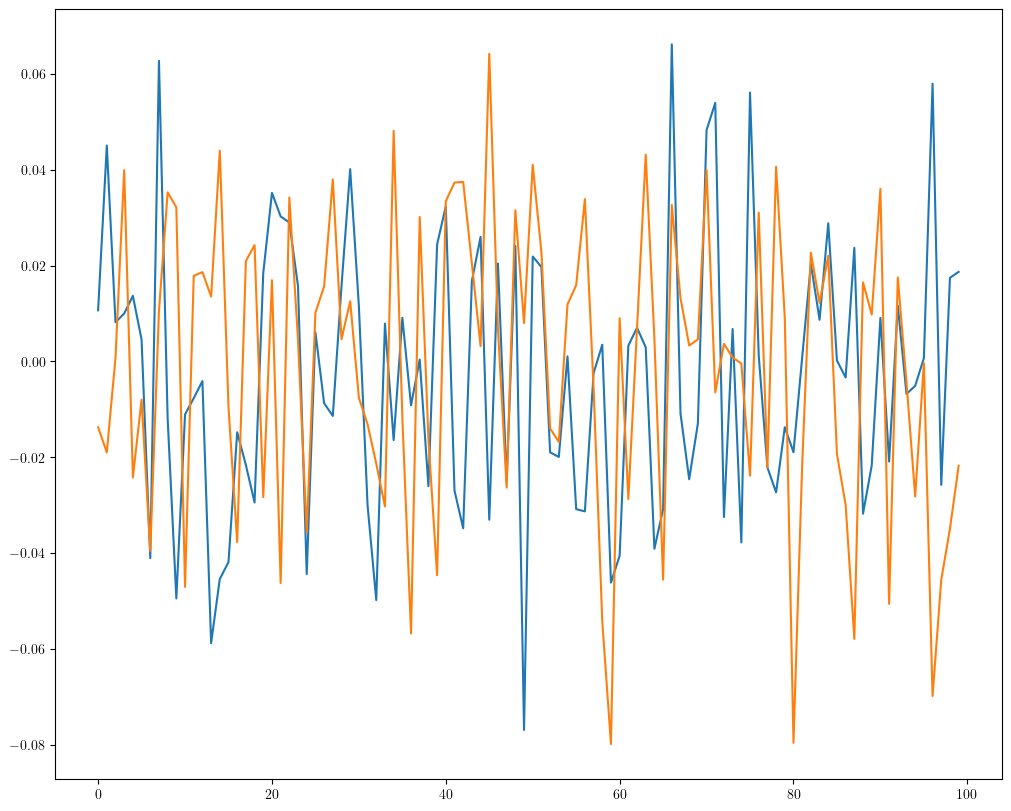

In [6]:
type(bm)
plt.plot(bm[0:2, 0:100].T)
plt.show()

The following cell only must be run when you have the heavy objects on disk

In [30]:
var1 = ds.heat_kernel_var(time_steps, hurst)
var2 = ds.heat_kernel_var(time_steps*extra_steps, hurst)
x = np.linspace(-half_support, half_support, points)
x0 = np.linspace(0, 2*half_support, points)
fbm_a = ds.fbm(gaussian, hurst, points, half_support)
fbm_bridge = ds.bridge(fbm_a, x0)

Creation of random drifts

````{admonition} Caution
:class: caution
**Do not run this if you have the objects stored on disk, rather run the next one**
````

In [8]:
print('Creating drifts')
# drifts and generators
## I require two different time steps so I can compare the variances
rand_drift1, ibn1, bH1, brownian_bridge1, x1, var1 = ds.drift(gaussian, hurst, points, half_support, time_steps)
rand_drift2, ibn2, bH2, brownian_bridge2, x2, var2 = ds.drift(gaussian, hurst, points, half_support, time_steps*extra_steps)
#weier_drift1, weier1, x3, var3 = ds.wdrift(alpha=hurst, points=points, half_support=half_support, time_steps=time_steps)
#weier_drift2, weier2, x4, var4 = ds.wdrift(alpha=hurst, points=points, half_support=half_support, time_steps=time_steps*extra_steps)

Creating drifts


In [ ]:
with open('rand_drift1.pickle', 'wb') as f:
    pickle.dump(rand_drift1, f)
with open('rand_drift2.pickle', 'wb') as f:
    pickle.dump(rand_drift2, f)

Creating drifts


Run this if you have the objects on disk

In [13]:
with open('rand_drift1.pickle', 'rb') as f:
    rand_drift1 = pickle.load(f)
with open('rand_drift2.pickle', 'rb') as f:
    rand_drift2 = pickle.load(f)

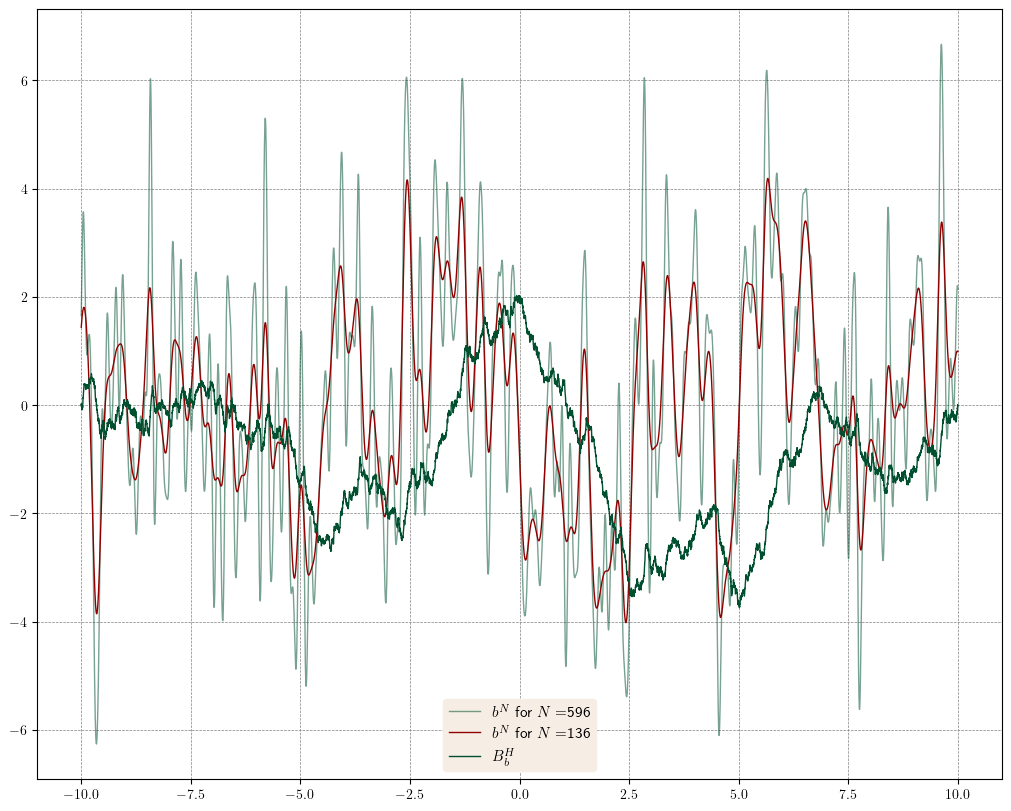

In [8]:
plot_drift(rand_drift1, rand_drift2, brownian_bridge1, x1)

Processing with $F(x) = \sin(x)$

If you have it on disk **do not run this**, run the next cell

In [9]:
print('Laws with sin(x)')
rand_mvlaw1_1 = ds.solve_fp(drift_a=rand_drift1, grid_a=x1, limx=half_support, nonlinear_f=nonlinear1, ts=time_start, te=time_end, xpoints=points, tpoints=time_steps)
print('Solutions with sin(x)')
rand_mvsoln1_1 = ds.solve_mv(y0=y0, drift_array=rand_drift1, z=bm, law=rand_mvlaw1_1, time_start=time_start, time_end=time_end, time_steps=time_steps, sample_paths=sample_paths, grid=x1, half_support=half_support, xpde=points, tpde=time_steps, nl=nonlinear1)
print('Laws with sin(x)')
rand_mvlaw1_2 = ds.solve_fp(drift_a=rand_drift2, grid_a=x2, limx=half_support, nonlinear_f=nonlinear1, ts=time_start, te=time_end, xpoints=points, tpoints=time_steps*extra_steps)
print('Solutions with sin(x)')
rand_mvsoln1_2 = ds.solve_mv(y0=y0, drift_array=rand_drift2, z=bm, law=rand_mvlaw1_2, time_start=time_start, time_end=time_end, time_steps=time_steps*extra_steps, sample_paths=sample_paths, grid=x2, half_support=half_support, xpde=points, tpde=time_steps*extra_steps, nl=nonlinear1)
print('DONE!!!')

Laws with sin(x)
Solutions with sin(x)
Laws with sin(x)
Solutions with sin(x)
DONE!!!


This is to save on disk and delete the objects from the python session to avoid runing out of memory

In [ ]:
with open('rand_mvlaw1_1.pickle', 'wb') as f:
    pickle.dump(rand_mvlaw1_1, f)
with open('rand_mvsoln1_1.pickle', 'wb') as f:
    pickle.dump(rand_mvsoln1_1, f)
with open('rand_mvlaw1_2.pickle', 'wb') as f:
    pickle.dump(rand_mvlaw1_2, f)
with open('rand_mvsoln1_2.pickle', 'wb') as f:
    pickle.dump(rand_mvsoln1_2, f)

In [ ]:
del rand_mvlaw1_1
del rand_mvsoln1_1
del rand_mvlaw1_2
del rand_mvsoln1_2

Run this if you have the objects on disk

In [15]:
with open('rand_mvlaw1_1.pickle', 'rb') as f:
    rand_mvlaw1_1 = pickle.load(f)
with open('rand_mvsoln1_1.pickle', 'rb') as f:
    rand_mvsoln1_1 = pickle.load(f)

with open('rand_mvlaw1_2.pickle', 'rb') as f:
    rand_mvlaw1_2 = pickle.load(f)
with open('rand_mvsoln1_2.pickle', 'rb') as f:
    rand_mvsoln1_2 = pickle.load(f)

In [11]:
x = np.linspace(-half_support, half_support, points)

In [10]:
plot_mckean_drift(rand_drift1, rand_drift2, rand_mvlaw1_1, rand_mvlaw1_2, nonlinear1, x)

NameError: name 'x' is not defined

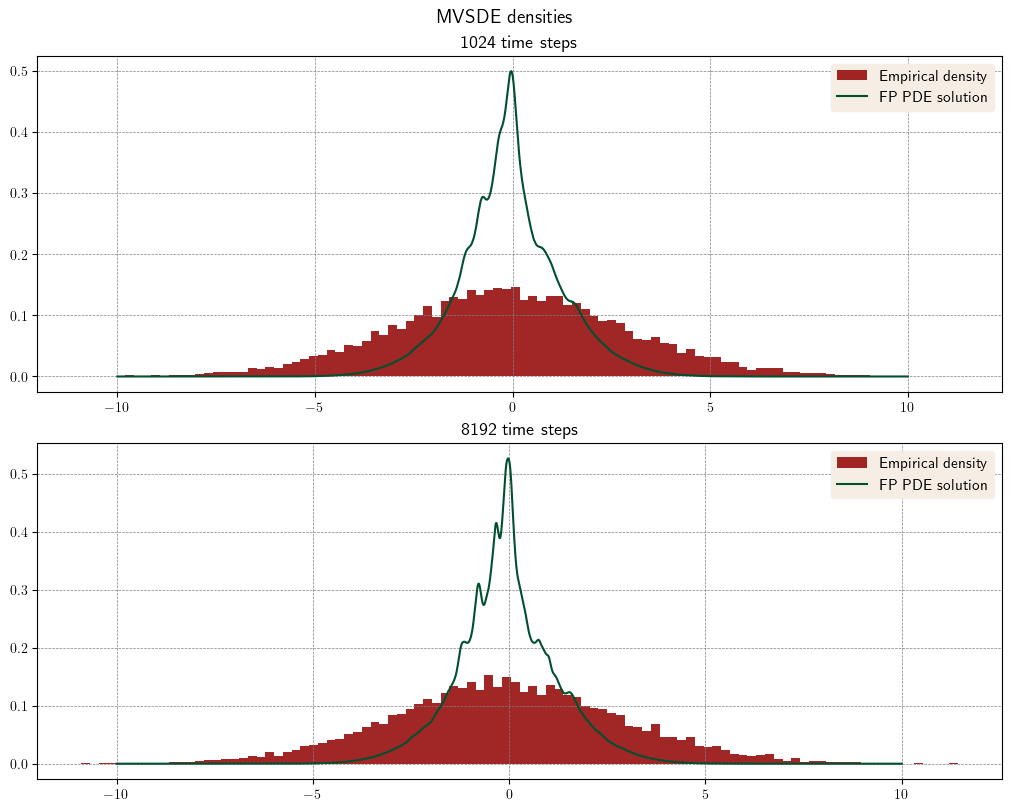

In [11]:
plot_mckean_law(rand_mvsoln1_1, rand_mvsoln1_2, x1, f'{time_steps} time steps', f'{time_steps*extra_steps} time steps')

Processing with $F(x) = \cos(x)$

If you have it on disk **do not run this**, run the next cell

In [ ]:
print('Laws with cos(x)')
rand_mvlaw2_1 = ds.solve_fp(drift_a=rand_drift1, grid_a=x1, limx=half_support, nonlinear_f=nonlinear2, ts=time_start, te=time_end, xpoints=points, tpoints=time_steps)
print('Solutions with cos(x)')
rand_mvsoln2_1 = ds.solve_mv(y0=y0, drift_array=rand_drift1, z=bm, law=rand_mvlaw2_1, time_start=time_start, time_end=time_end, time_steps=time_steps, sample_paths=sample_paths, grid=x1, half_support=half_support, xpde=points, tpde=time_steps, nl=nonlinear2)
with open('rand_mvlaw2_1.pickle', 'wb') as f:
    pickle.dump(rand_mvlaw2_1, f)
del rand_mvlaw2_1
with open('rand_mvsoln2_1.pickle', 'wb') as f:
    pickle.dump(rand_mvsoln2_1, f)
del rand_mvsoln2_1
rand_mvlaw2_2 = ds.solve_fp(drift_a=rand_drift2, grid_a=x2, limx=half_support, nonlinear_f=nonlinear2, ts=time_start, te=time_end, xpoints=points, tpoints=time_steps*extra_steps)
print('Solutions with cos(x)')
rand_mvsoln2_2 = ds.solve_mv(y0=y0, drift_array=rand_drift2, z=bm, law=rand_mvlaw2_2, time_start=time_start, time_end=time_end, time_steps=time_steps, sample_paths=sample_paths, grid=x2, half_support=half_support, xpde=points, tpde=time_steps*extra_steps, nl=nonlinear2)
with open('rand_mvlaw2_2.pickle', 'wb') as f:
    pickle.dump(rand_mvlaw2_2, f)
del rand_mvlaw2_2
with open('rand_mvsoln2_2.pickle', 'wb') as f:
    pickle.dump(rand_mvsoln2_2, f)
del rand_mvsoln2_2

Run this if you have the objects on disk

In [15]:
with open('rand_mvlaw2_1.pickle', 'rb') as f:
    rand_mvlaw2_1 = pickle.load(f)
with open('rand_mvsoln2_1.pickle', 'rb') as f:
    rand_mvsoln2_1 = pickle.load(f)

with open('rand_mvlaw2_2.pickle', 'rb') as f:
    rand_mvlaw2_2 = pickle.load(f)
with open('rand_mvsoln2_2.pickle', 'rb') as f:
    rand_mvsoln2_2 = pickle.load(f)

In [ ]:
print('Laws with sin(10x)')
rand_mvlaw3_1 = ds.solve_fp(drift_a=rand_drift1, grid_a=x1, limx=half_support, nonlinear_f=nonlinear3, ts=time_start, te=time_end, xpoints=points, tpoints=time_steps)
print('Solutions with sin(10x)')
rand_mvsoln3_1 = ds.solve_mv(y0=y0, drift_array=rand_drift1, z=bm, law=rand_mvlaw3_1, time_start=time_start, time_end=time_end, time_steps=time_steps, sample_paths=sample_paths, grid=x1, half_support=half_support, xpde=points, tpde=time_steps, nl=nonlinear3)
with open('rand_mvlaw3_1.pickle', 'wb') as f:
    pickle.dump(rand_mvlaw3_1, f)
del rand_mvlaw3_1
with open('rand_mvsoln3_1.pickle', 'wb') as f:
    pickle.dump(rand_mvsoln3_1, f)
del rand_mvsoln3_1
rand_mvlaw3_2 = ds.solve_fp(drift_a=rand_drift2, grid_a=x2, limx=half_support, nonlinear_f=nonlinear3, ts=time_start, te=time_end, xpoints=points, tpoints=time_steps*extra_steps)
print('Solutions with sin(10x)')
rand_mvsoln3_2 = ds.solve_mv(y0=y0, drift_array=rand_drift2, z=bm, law=rand_mvlaw3_2, time_start=time_start, time_end=time_end, time_steps=time_steps, sample_paths=sample_paths, grid=x2, half_support=half_support, xpde=points, tpde=time_steps*extra_steps, nl=nonlinear3)
with open('rand_mvlaw3_2.pickle', 'wb') as f:
    pickle.dump(rand_mvlaw3_2, f)
del rand_mvlaw3_2
with open('rand_mvsoln3_2.pickle', 'wb') as f:
    pickle.dump(rand_mvsoln3_2, f)
del rand_mvsoln3_2

In [ ]:
print('Laws with cos(10x)')
rand_mvlaw4_1 = ds.solve_fp(drift_a=rand_drift1, grid_a=x1, limx=half_support, nonlinear_f=nonlinear4, ts=time_start, te=time_end, xpoints=points, tpoints=time_steps)
print('Solutions with cos(10x)')
rand_mvsoln4_1 = ds.solve_mv(y0=y0, drift_array=rand_drift1, z=bm, law=rand_mvlaw4_1, time_start=time_start, time_end=time_end, time_steps=time_steps, sample_paths=sample_paths, grid=x1, half_support=half_support, xpde=points, tpde=time_steps, nl=nonlinear4)
with open('rand_mvlaw4_1.pickle', 'wb') as f:
    pickle.dump(rand_mvlaw4_1, f)
del rand_mvlaw4_1
with open('rand_mvsoln4_1.pickle', 'wb') as f:
    pickle.dump(rand_mvsoln4_1, f)
del rand_mvsoln4_1
rand_mvlaw4_2 = ds.solve_fp(drift_a=rand_drift2, grid_a=x2, limx=half_support, nonlinear_f=nonlinear4, ts=time_start, te=time_end, xpoints=points, tpoints=time_steps*extra_steps)
print('Solutions with cos(10x)')
rand_mvsoln4_2 = ds.solve_mv(y0=y0, drift_array=rand_drift2, z=bm, law=rand_mvlaw4_2, time_start=time_start, time_end=time_end, time_steps=time_steps, sample_paths=sample_paths, grid=x2, half_support=half_support, xpde=points, tpde=time_steps*extra_steps, nl=nonlinear4)
with open('rand_mvlaw4_2.pickle', 'wb') as f:
    pickle.dump(rand_mvlaw4_2, f)
del rand_mvlaw4_2
with open('rand_mvsoln4_2.pickle', 'wb') as f:
    pickle.dump(rand_mvsoln4_2, f)
del rand_mvsoln4_2

In [ ]:
print('Laws with -sigmoid(x)')
rand_mvlaw5_1 = ds.solve_fp(drift_a=rand_drift1, grid_a=x1, limx=half_support, nonlinear_f=nonlinear5, ts=time_start, te=time_end, xpoints=points, tpoints=time_steps)
print('Solutions with -sigmoid(x)')
rand_mvsoln5_1 = ds.solve_mv(y0=y0, drift_array=rand_drift1, z=bm, law=rand_mvlaw5_1, time_start=time_start, time_end=time_end, time_steps=time_steps, sample_paths=sample_paths, grid=x1, half_support=half_support, xpde=points, tpde=time_steps, nl=nonlinear5)
with open('rand_mvlaw5_1.pickle', 'wb') as f:
    pickle.dump(rand_mvlaw5_1, f)
del rand_mvlaw5_1
with open('rand_mvsoln5_1.pickle', 'wb') as f:
    pickle.dump(rand_mvsoln5_1, f)
del rand_mvsoln5_1
rand_mvlaw5_2 = ds.solve_fp(drift_a=rand_drift2, grid_a=x2, limx=half_support, nonlinear_f=nonlinear5, ts=time_start, te=time_end, xpoints=points, tpoints=time_steps*extra_steps)
print('Solutions with -sigmoid(x)')
rand_mvsoln5_2 = ds.solve_mv(y0=y0, drift_array=rand_drift2, z=bm, law=rand_mvlaw5_2, time_start=time_start, time_end=time_end, time_steps=time_steps, sample_paths=sample_paths, grid=x2, half_support=half_support, xpde=points, tpde=time_steps*extra_steps, nl=nonlinear5)
with open('rand_mvlaw5_2.pickle', 'wb') as f:
    pickle.dump(rand_mvlaw5_2, f)
del rand_mvlaw5_2
with open('rand_mvsoln5_2.pickle', 'wb') as f:
    pickle.dump(rand_mvsoln5_2, f)
del rand_mvsoln5_2

In [ ]:
print('Laws with sigmoid(x)')
rand_mvlaw6_1 = ds.solve_fp(drift_a=rand_drift1, grid_a=x1, limx=half_support, nonlinear_f=nonlinear6, ts=time_start, te=time_end, xpoints=points, tpoints=time_steps)
print('Solutions with sigmoid(x)')
rand_mvsoln6_1 = ds.solve_mv(y0=y0, drift_array=rand_drift1, z=bm, law=rand_mvlaw6_1, time_start=time_start, time_end=time_end, time_steps=time_steps, sample_paths=sample_paths, grid=x1, half_support=half_support, xpde=points, tpde=time_steps, nl=nonlinear6)
with open('rand_mvlaw6_1.pickle', 'wb') as f:
    pickle.dump(rand_mvlaw6_1, f)
del rand_mvlaw6_1
with open('rand_mvsoln6_1.pickle', 'wb') as f:
    pickle.dump(rand_mvsoln6_1, f)
del rand_mvsoln6_1
rand_mvlaw6_2 = ds.solve_fp(drift_a=rand_drift2, grid_a=x2, limx=half_support, nonlinear_f=nonlinear6, ts=time_start, te=time_end, xpoints=points, tpoints=time_steps*extra_steps)
print('Solutions with sigmoid(x)')
rand_mvsoln6_2 = ds.solve_mv(y0=y0, drift_array=rand_drift2, z=bm, law=rand_mvlaw6_2, time_start=time_start, time_end=time_end, time_steps=time_steps, sample_paths=sample_paths, grid=x2, half_support=half_support, xpde=points, tpde=time_steps*extra_steps, nl=nonlinear6)
with open('rand_mvlaw6_2.pickle', 'wb') as f:
    pickle.dump(rand_mvlaw6_2, f)
del rand_mvlaw6_2
with open('rand_mvsoln6_2.pickle', 'wb') as f:
    pickle.dump(rand_mvsoln6_2, f)
del rand_mvsoln6_2

In [ ]:
###############
# This is not possible because of the resolution change, do not multiply time_steps*extra steps
# Rather create first the big one and then divide
###############
# rand_mvsoln2 = ds.solve_mv(y0=y0, drift_array=rand_drift2, z=bm, law=rand_mvlaw2,
#                            time_start=time_start, time_end=time_end, time_steps=time_steps*extra_steps,
#                            sample_paths=sample_paths, grid=x2, half_support=half_support,
#                            xpde=points, tpde=time_steps, nl=nonlinear1)
# But we can use a different nonlinear function